# Intel Image Classification
This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

In [1]:
import os
import jovian
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
project_name='image_classification_project'

In [3]:
credentials = {"username":"myusername","key":"mykey"}
os.environ['KAGGLE_USERNAME']=credentials["username"]
os.environ['KAGGLE_KEY']=credentials["key"]

## Setting up the data

In [4]:
!kaggle datasets download -d puneet6060/intel-image-classification

 96% 334M/346M [00:03<00:00, 110MB/s] 
100% 346M/346M [00:03<00:00, 91.8MB/s]


In [5]:
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jpg  
  inflating: seg_train/seg_train/mountain/7695.jp

## Data augmentations on images

In [6]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

tfms = tt.Compose([
                  tt.Resize([150,150]),
                  tt.RandomHorizontalFlip(), 
                  tt.ToTensor(),
                  tt.Normalize(*stats,inplace=True)
                  ])

dataset = ImageFolder('/content/seg_train/seg_train/', tfms)

In [7]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 150, 150]) 0


tensor([[[ 2.3590,  2.3590,  2.3784,  ...,  2.3784,  2.3590,  2.3590],
         [ 2.3590,  2.3590,  2.3784,  ...,  2.3590,  2.3590,  2.3396],
         [ 2.3590,  2.3590,  2.3784,  ...,  2.3590,  2.3396,  2.3396],
         ...,
         [-0.6069, -1.5567, -1.4404,  ..., -1.4792, -1.2272, -1.5180],
         [-1.6731, -1.3629, -2.0026,  ..., -1.5955, -1.5180, -0.9364],
         [-1.2078, -1.4404, -1.8281,  ..., -1.2660, -1.3629, -1.2854]],

        [[ 2.4395,  2.4395,  2.4591,  ...,  2.4591,  2.4395,  2.4395],
         [ 2.4395,  2.4395,  2.4591,  ...,  2.4395,  2.4395,  2.4198],
         [ 2.4395,  2.4395,  2.4591,  ...,  2.4395,  2.4198,  2.4198],
         ...,
         [-0.6679, -1.6316, -1.5136,  ..., -1.4742, -1.2186, -1.5136],
         [-1.7496, -1.4349, -2.0839,  ..., -1.5922, -1.5136, -0.9236],
         [-1.2776, -1.5136, -1.9069,  ..., -1.2579, -1.3562, -1.2776]],

        [[ 2.5586,  2.5586,  2.6172,  ...,  2.5781,  2.5586,  2.5586],
         [ 2.5586,  2.5586,  2.6172,  ...,  2

In [8]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  buildings (0)


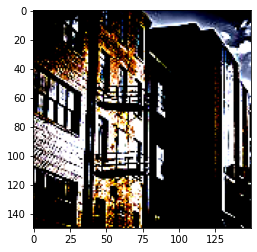

In [9]:
show_example(*dataset[100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  forest (1)


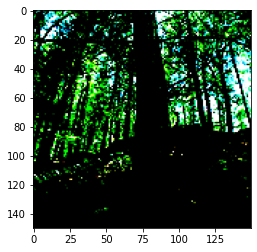

In [10]:
show_example(*dataset[3000])

In [11]:
random_seed = 42
torch.manual_seed(random_seed);

In [12]:
val_size = 1000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
print("Length of training dataset:",len(train_ds))
print("Length of validation dataset:",len(val_ds))

Length of training dataset: 13034
Length of validation dataset: 1000


In [13]:
# Look into the data directory
data_dir = '/content'
print("Data directory contents:",os.listdir(data_dir))
classes = os.listdir(data_dir + "/seg_train/seg_train")
print("Classes:",classes)

Data directory contents: ['.config', 'seg_train', 'seg_test', 'seg_pred', 'intel-image-classification.zip', 'sample_data']
Classes: ['buildings', 'forest', 'street', 'sea', 'mountain', 'glacier']


In [14]:
batch_size = 32

In [15]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

In [16]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


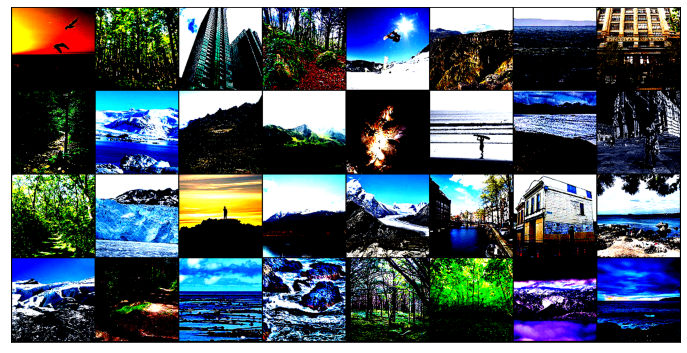

In [17]:
show_batch(train_dl)

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Creating the Model

In [21]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2),
    nn.MaxPool2d(2, 2)
)

In [22]:
to_device(simple_model, device);

In [23]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([32, 3, 150, 150])
out.shape: torch.Size([32, 8, 37, 37])


In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [25]:
class IntelModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 75 x 75

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 37 x 37

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 18 x 18

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 9 x 9

            nn.Flatten(),
            nn.Linear(512*9*9, 2048),
            nn.ReLU(), 
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [26]:
model = IntelModel()
model

IntelModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1

In [27]:
to_device(model, device);

In [28]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 150, 150])
out.shape: torch.Size([32, 10])
out[0]: tensor([-0.0225, -0.0309,  0.0171,  0.0431, -0.0310, -0.0056,  0.0245, -0.0187,
        -0.0405, -0.0183], device='cuda:0', grad_fn=<SelectBackward>)


In [29]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(valid_dl, device)

In [30]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Training the Model

In [31]:
model = to_device(IntelModel(), device)

In [32]:
evaluate(model, val_dl)

{'val_acc': 0.0, 'val_loss': 2.309413433074951}

In [33]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [34]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 1.3220, val_loss: 0.9022, val_acc: 0.6150



Epoch [1], train_loss: 0.8785, val_loss: 0.7804, val_acc: 0.6939



Epoch [2], train_loss: 0.7201, val_loss: 0.6799, val_acc: 0.7451



Epoch [3], train_loss: 0.6318, val_loss: 0.6292, val_acc: 0.7613



Epoch [4], train_loss: 0.5530, val_loss: 0.5709, val_acc: 0.7869


In [35]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

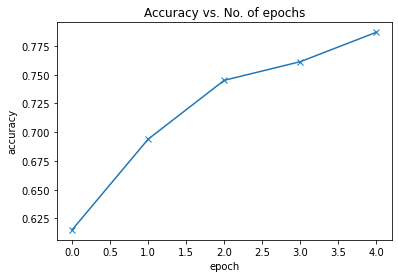

In [36]:
plot_accuracies(history)

In [37]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

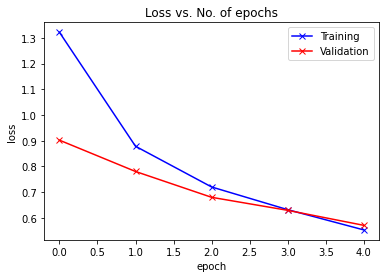

In [38]:
plot_losses(history)

## Testing the CNN Model

In [39]:
test_tfms = tt.Compose([
                         tt.Resize([150,150]),
                         tt.ToTensor(),
                         tt.Normalize(*stats)
                         ])

In [40]:
test_dataset = ImageFolder('/content/seg_test/seg_test', transform=test_tfms)

In [41]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: street , Predicted: street


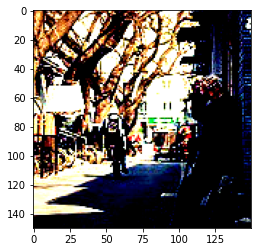

In [42]:
img, label = test_dataset[2600]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: glacier , Predicted: glacier


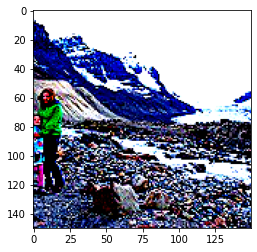

In [43]:
img, label = test_dataset[1005]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: forest , Predicted: forest


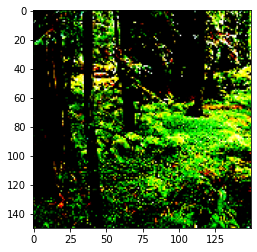

In [44]:
img, label = test_dataset[653]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [45]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.8122150301933289, 'val_loss': 0.5306295156478882}

In [46]:
# Saving the model weights
torch.save(model.state_dict(), 'intel-cnn.pth')

In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..


In [46]:
print('a')

a
